In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [2]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

In [3]:
mnist['data'].shape, mnist['target'].shape

((70000, 784), (70000,))

In [4]:
def relu(x):
    
    return np.maximum(0, x)

In [5]:
x = np.array([0.1, -0.9, 0.5])
relu(x)

array([0.1, 0. , 0.5])

In [6]:
def softmax(x):
    
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [7]:
def cross_entropy_error(y, t):
    
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [8]:
def softmax_loss(X, t):
    
    y = softmax(X)
    return cross_entropy_error(y, t)

In [9]:
def init_network():
    
    network = {}
    network['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network['b1'] = np.array([0.1, 0.2, 0.3])
    network['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network['b2'] = np.array([0.1, 0.2])
    network['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network['b3'] = np.array([0.1, 0.2])
    return network

def forward(network, x):
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = relu(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = relu(a2)
    y = np.dot(z2, W3) + b3
    return y

network = init_network()
x = np.array([1.0, 0.5])
forward(network, x)

array([0.426, 0.912])

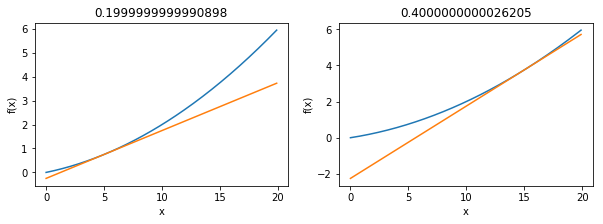

In [10]:
def numerical_diff(f, x):
    
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

def function_1(x):
    
    return 0.01*x**2 + 0.1*x 

def tangent_line(f, x):
    
    d = numerical_diff(f, x)
    y = f(x) - d*x
    return d, lambda t: d*t + y
     
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

x = np.arange(0, 20, 0.1)
y = function_1(x)
d, tf = tangent_line(function_1, 5)
y2 = tf(x)
axs[0].plot(x, y)
axs[0].plot(x, y2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_title(d)

d, tf = tangent_line(function_1, 15)
y2 = tf(x)
axs[1].plot(x, y)
axs[1].plot(x, y2)
axs[1].set_xlabel('x')
axs[1].set_ylabel('f(x)')
axs[1].set_title(d)

plt.show()

In [11]:
def function_2(x):
    
    return x[0]**2+x[1]**2

def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad

def numerical_gradient(f, X):
    
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

In [12]:
numerical_gradient(function_2, np.array([3.0, 4.0])), numerical_gradient(function_2, np.array([0.0, 2.0]))

(array([6., 8.]), array([0., 4.]))

In [13]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    
    x = init_x
    
    for i in range(step_num):
        
        grad = numerical_gradient(f, x)
        x -= lr*grad
        
    return x

In [14]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=0.1)

array([-6.11110793e-10,  8.14814391e-10])

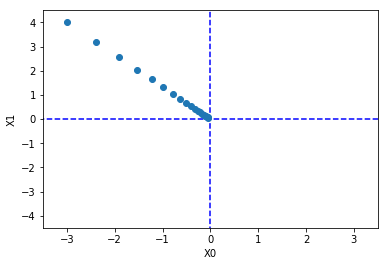

In [15]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    
    x = init_x
    x_history = []

    for i in range(step_num):
        
        x_history.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr*grad

    return x, np.array(x_history)

init_x = np.array([-3.0, 4.0])    

x, x_history = gradient_descent(function_2, init_x, lr=0.1, step_num=20)

plt.plot([-5, 5], [0,0], '--b')
plt.plot([0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [16]:
class simpleNet:
    
    def __init__(self):
        
        self.W = np.random.randn(2, 3) # ガウス分布で初期化
    
    def predict(self, x):
        
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [17]:
net = simpleNet()
print(net.W) # 重み
print('-'*50)

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p)) # 最大値のインデックス
print('-'*50)

t = np.array([0, 0, 1]) # 正解ラベル
loss = net.loss(x, t)
print(loss)

[[-0.66827157  0.07011927 -0.35464921]
 [-1.37983988 -0.34880307 -0.81537749]]
--------------------------------------------------
[-1.64281884 -0.2718512  -0.94662926]
1
--------------------------------------------------
1.2418687133687607


In [18]:
def f(W):
    return net.loss(x, t)
#f = lambda w: net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.08638989  0.34030365 -0.42669354]
 [ 0.12958484  0.51045548 -0.64004032]]


In [19]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1)+b1
        z1 = relu(a1)
        a2 = np.dot(z1, W2)+b2
        y = softmax(a2)
        return y
    
    def loss(self, x, t):
        
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

In [20]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape

(784, 100)

In [21]:
mnist['data'][0:5].shape

(5, 784)

In [22]:
x = mnist['data'][0:5]
y = net.predict(x)
y

array([[5.68326060e-04, 4.11173845e-02, 4.75311372e-02, 1.88275679e-02,
        2.98368196e-01, 1.19696826e-02, 1.61587866e-02, 2.40639996e-01,
        1.65636892e-01, 1.59182031e-01],
       [2.95563975e-03, 1.99426097e-02, 7.61153714e-02, 5.69043576e-02,
        9.65450150e-02, 1.13019661e-02, 8.66045937e-02, 2.17122275e-01,
        3.57711902e-01, 7.47962704e-02],
       [5.15881945e-03, 5.55072522e-02, 1.46189935e-02, 3.05710115e-01,
        4.09228173e-02, 2.90523787e-01, 4.00246161e-02, 1.94539311e-01,
        3.60850123e-02, 1.69092763e-02],
       [1.16869148e-03, 7.84094915e-02, 1.34676665e-02, 1.10777887e-01,
        3.91081152e-02, 1.48409194e-02, 2.46437917e-02, 6.45542716e-01,
        2.14106181e-02, 5.06301034e-02],
       [2.09797868e-04, 9.06799164e-02, 5.14427306e-01, 2.54898703e-02,
        2.75006411e-02, 2.79284443e-03, 6.85730986e-02, 1.45720479e-01,
        5.55466884e-02, 6.90593576e-02]])

In [23]:
x = mnist['data'][0:5]
x = x.astype(np.float)
x /= 255
t = mnist['target'][0:5]
t = t.astype(np.int)
t_one_hot = np.zeros((len(t), 10))
t_one_hot[np.arange(len(t)), t] = 1

grads = net.numerical_gradient(x, t_one_hot)
grads['W1'].shape, grads['b1'].shape, grads['W2'].shape, grads['b2'].shape

((784, 100), (100,), (100, 10), (10,))

In [24]:
iters_num = 100
batch_size = 100
learning_rate = 0.1

net = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

data_x = mnist['data']
data_x = data_x.astype(np.float)
data_x /= 255

data_t = mnist['target']
data_t = data_t.astype(np.int)
data_t_one_hot = np.zeros((len(data_t), 10))
data_t_one_hot[np.arange(len(data_t)), data_t] = 1

indices = np.random.permutation(len(data_x)) # shuffle

train_indices = indices[:1000] # 1000件学習用データ
test_indices = indices[1000:1500] # 500件評価用データ

train_x = data_x[train_indices]
train_t = data_t_one_hot[train_indices]
test_x = data_x[test_indices]
test_t = data_t_one_hot[test_indices]

train_size = len(train_x)

train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in tqdm(range(iters_num), file=sys.stdout):
    
    # ミニバッチ
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_x[batch_mask]
    t_batch = train_t[batch_mask]
    
    # 勾配の計算
    grad = net.numerical_gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= learning_rate*grad[key]
        
    # 学習経過の記録
    train_loss = net.loss(x_batch, t_batch)
    train_loss_list.append(train_loss)
    train_acc = net.accuracy(train_x, train_t)
    train_acc_list.append(train_acc)
    test_acc = net.accuracy(test_x, test_t)
    test_acc_list.append(test_acc)
    tqdm.write('i:\t{}\ttrain_loss:\t{}\ttrain_acc:\t{}\ttest_acc:\t{}'.format(i, train_loss, train_acc, test_acc))

i:	0	train_loss:	2.3009407812242744	train_acc:	0.159	test_acc:	0.136
i:	1	train_loss:	2.2994501320776566	train_acc:	0.14	test_acc:	0.106
i:	2	train_loss:	2.2985132262166443	train_acc:	0.153	test_acc:	0.12
i:	3	train_loss:	2.2985599072107745	train_acc:	0.215	test_acc:	0.152
i:	4	train_loss:	2.2976375306257033	train_acc:	0.22	test_acc:	0.16
i:	5	train_loss:	2.295446456913539	train_acc:	0.199	test_acc:	0.148
i:	6	train_loss:	2.2920106101863276	train_acc:	0.235	test_acc:	0.17
i:	7	train_loss:	2.2931361495924465	train_acc:	0.239	test_acc:	0.17
i:	8	train_loss:	2.29711887847072	train_acc:	0.238	test_acc:	0.17
i:	9	train_loss:	2.292493144052164	train_acc:	0.235	test_acc:	0.166
i:	10	train_loss:	2.2942653715698196	train_acc:	0.24	test_acc:	0.174
i:	11	train_loss:	2.2944521264171924	train_acc:	0.229	test_acc:	0.162
i:	12	train_loss:	2.2922903391803056	train_acc:	0.248	test_acc:	0.178
i:	13	train_loss:	2.2884067575536426	train_acc:	0.259	test_acc:	0.184
i:	14	train_loss:	2.2866709428234997	train

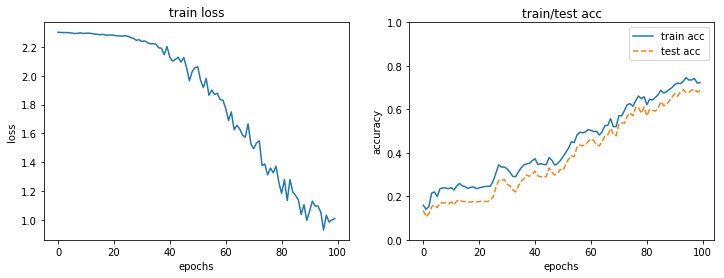

In [32]:
x = np.arange(iters_num)

fig, axs = plt.subplots(ncols=2, figsize=(12,4))

axs[0].plot(x, train_loss_list)
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].set_title('train loss')

axs[1].plot(x, train_acc_list, label='train acc')
axs[1].plot(x, test_acc_list, label='test acc', linestyle='--')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0, 1.0)
axs[1].set_title('train/test acc')

plt.legend()
plt.show()